
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Voice2Violin Colab

December 6th [hanoih@] - This is a colab notebook that enables a user to record input via the laptop microphone directly into colab and have the sound resynthsized into a violin. The input can be singing or an instrument, but has to be monophonic.


# Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import os
import time

from colabtools import sound
from colabtools import drive
from colabtools import auth

import gin
import librosa
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn
import scipy
import scipy.io.wavfile as wavfile
import tensorflow as tf
import tensorflow_datasets as tfds

import crepe
from colabtools import drive
from colabtools import auth
from google3.pyglib import gfile

import ddsp 
from ddsp.training  import data 
from ddsp.training  import eval_util 
from ddsp.training  import model as model_lib
from ddsp.training  import nn
from ddsp.training  import train_util

from google3.learning.brain.research.magenta.models.ddsp.training import data as data_internal

synths = ddsp.synths
spectral_ops = ddsp.spectral_ops

SR = 16000
play = lambda x: sound.Play(x, SR)

In [0]:
# Functions for loading audio in DDSP

def specplot(audio, vmin=-6, vmax=1, rotate=True, size=1024, figsize=(12, 4)):
  # with tf.Session() as sess:
  mag = sess.run(spectral_ops.calc_logmag(audio, size=size))
  if rotate:
    mag = np.rot90(mag)
  matfig = plt.figure(figsize=figsize)
  plt.matshow(mag, vmin=vmin, vmax=vmax, fignum=matfig.number, aspect='auto')

def load_wav(filename):
  with tf.gfile.Open(filename, 'r') as f:
    sr, audio = scipy.io.wavfile.read(f)

  float_normalizer = float(np.iinfo(np.int16).max)
  audio = audio / float_normalizer
  if audio.ndim == 2:
    audio = np.mean(audio, axis=-1)

  audio = librosa.resample(audio, sr, 16000)
  return audio


def load_wav_from_drive(file_id, sr=16000):
  wav_str = drive.LoadFile(file_id=file_id)
  filename = '/tmp/{}.wav'.format(file_id)
  with gfile.Open(filename, 'w') as f:
    f.write(wav_str)
  wav_data = librosa.load(filename, sr=sr)[0]
  return wav_data


def save_fig(path, type='pdf', dpi=300):
  path = os.path.splitext(path)[0]
  path += '.{}'.format(type)
  with gfile.GFile(path, 'w') as f:
    plt.savefig(f, format=type, transparent=True, dpi=dpi)
  print('Figure saved to: {}'.format(path))


def specplot_show(audio, axis, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  with tf.Session() as sess:
    a = tf.convert_to_tensor(audio, tf.float32)
    logmag_ = sess.run(spectral_ops.calc_logmag(a, size=size))
  if rotate:
    logmag_ = np.rot90(logmag_)
  axis.matshow(logmag_, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  axis.set_xticks([])
  axis.set_yticks([])


def gen_harmonic_wave(phase, mags, phase_offsets):
  audio = np.zeros_like(phase)
  for i, (mag, phase_offset) in enumerate(zip(mags, phase_offsets)):
    freq_multiplier = i + 1
    audio += mag * np.sin( 2.0 * np.pi * (freq_multiplier * phase + phase_offset))
  return audio


def f32(tensor):
  return tf.convert_to_tensor(tensor, dtype=tf.float32)


#Imports for singing into Colab

In [0]:
#vox2perf imports
import base64
import cStringIO
import tempfile
import scipy
from google3.video.common.subprocess.ffmpeg import ffmpeg_pb2
from google3.video.common.subprocess.ffmpeg.python import pywrapffmpeg
from google3.video.common.subprocess.ffmpeg.python import set_ffmpeg_binary_flags
from colabtools import frontend

In [0]:
RECORD_SAMPLE_RATE=16000
NSYNTH_SAMPLE_RATE=16000

In [0]:
def rescale(input_vector, new_min, new_max):
  numerator = input_vector - np.min(input_vector)
  denominator = np.max(input_vector) - np.min(input_vector)
  new_range = new_max - new_min
  return ((numerator/denominator)*new_range) + new_min

def _uri_to_bytes(uri):
  """Decode WebM audio URI to bytes."""
  format_string = 'data:audio/webm;base64,'
  assert uri.startswith(format_string)
  return base64.standard_b64decode(uri[len(format_string):])

def _bytes_to_wav_data(bytes, desired_sample_rate):
  """Extracts float samples from WebM encoding, resampled to desired rate."""
  ffmpeg_infile = tempfile.NamedTemporaryFile(suffix='.webm')
  ffmpeg_infile.write(bytes)
  params = ffmpeg_pb2.FfmpegParams()
  params.input.add(file_name=ffmpeg_infile.name)
  output = params.output.add()
  ffmpeg_outfile = tempfile.NamedTemporaryFile(suffix='.wav')
  output.file_name = ffmpeg_outfile.name
  output.container.format = ffmpeg_pb2.FfmpegParams.FORMAT_ID_WAV
  output.audio.add(num_channels=1, sample_rate=desired_sample_rate)
  config = ffmpeg_pb2.FfmpegConfig()
  set_ffmpeg_binary_flags.SetFfmpegBinaryFlags()
  ffmpeg = pywrapffmpeg.Ffmpeg()
  assert ffmpeg.Init(config, params), ('Failed to initialize ffmpeg. Error: %s',
                                       ffmpeg.GetOutputLog())
  assert ffmpeg.Run(), ('Failed to run ffmpeg. Error: %s',
                        ffmpeg.GetOutputLog())
  return open(ffmpeg_outfile.name).read()

def record_audio(sample_rate):
  """Records microphone audio at sample_rate, returning float samples."""
  uri = frontend.RecordMedia(
    audio={
        'mandatory': {
            'googEchoCancellation': False,
            'googAutoGainControl': False,
            'googNoiseSuppression': False,
            'googHighpassFilter': False,
            'googTypingNoiseDetection': False,
            'googBeamforming': False,
            'echoCancellation': False,
        }
    }, video=False)
  bytes = _uri_to_bytes(uri)
  return _bytes_to_wav_data(bytes, sample_rate)

def record_audio_from_mic():
  # Record audio from microphone.
  wav_data = record_audio(sample_rate=RECORD_SAMPLE_RATE)

  # Play the recorded audio.
  f = cStringIO.StringIO(wav_data)
  sample_rate, samples = scipy.io.wavfile.read(f)
  assert sample_rate == RECORD_SAMPLE_RATE
  y = samples / 32768.0
  sound.Play(y, RECORD_SAMPLE_RATE)
  y = y / np.max(np.abs(y))
  return y

# Pick a Model

In [0]:
# Choose Model

### 11/13 third_party refactor
MODEL_DIR = "/cns/oi-d/home/brain-arts/experiments/rs=6.3/hanoih-ddsp-exp/hanoih-ddsp_9971260_fc_0_rnn_256" # violin model 

# Predict for a Batch of Data

## Load Gin Params

In [0]:
GIN_FILES = [os.path.join(MODEL_DIR, 'operative_config-0.gin')]
GIN_PARAMS = []

with gin.unlock_config():
  gin.parse_config_files_and_bindings(GIN_FILES, GIN_PARAMS)

batch_size = gin.query_parameter('train_util.create_estimator.batch_size')
params = {'batch_size': batch_size,
          'model_dir': MODEL_DIR}

## Get a Batch of Data

In [0]:
tf.reset_default_graph()
solo_violin_data = data_internal.SoloViolin()
input_fn = solo_violin_data.get_input_fn()

batch = tfds.as_numpy(input_fn(params))
batch_ = batch.next()
features_ = batch_[0]

In [0]:
def rms(audio):
  return np.mean(audio**2.0)**0.5


VIOLIN_RMS = rms(features_['audio'])

def norm_rms(audio, norm_value=VIOLIN_RMS):
  audio_rms = rms(audio)
  return audio / audio_rms * norm_value

print(VIOLIN_RMS)

0.08195020441355065


## Make Predictions

In [0]:
tf.reset_default_graph()
features_tf = {k:tf.convert_to_tensor(v) for k, v in features_.items()}

# Get model predictions for the batch.
model = model_lib.Model()
predictions = model.get_outputs(features_tf, is_training=False)

# Setup the session.
sess = tf.Session('uptc://prod/dragonfish_2x2')
#sess = tf.Session()

model.restore(sess, MODEL_DIR)

print(predictions.keys())

['reverb', 'loudness', 'losses/spectral_loss', 'decoder_outputs', 'additive', 'add2', 'total_loss', 'f0_confidence', 'noise', 'processor_group', 'f0_hz', 'f0', 'split', 'audio_gen', 'audio', 'add']


In [0]:
# Run a batch of predictions.
start_time = time.time()
predictions_ = sess.run(predictions)
print('Prediction took %.1f seconds' % (time.time() - start_time))

Prediction took 10.3 seconds


## Analyze results

In [0]:
# Predictions
k = 1

# Get audio
audio = features_['audio'][k]
audio_synth = predictions_['audio_gen'][k]
audio_synth_pre_effect = predictions_['add']['signal'][k]
audio_additive = predictions_['additive']['signal'][k]
audio_noise = predictions_['noise']['signal'][k]

# Get controls
add_controls_ = predictions_['additive']['controls']
amps = predictions_['additive']['controls']['amplitudes'][k]
harmonic_distribution =  predictions_['additive']['controls']['harmonic_distribution'][k]
noise_magnitudes =  predictions_['noise']['controls']['magnitudes'][k]
ir = predictions_['reverb']['controls']['impulse_response'][k]

# Get conditioning
f0_hz = predictions_['f0_hz'][k]
loudness = predictions_['loudness'][k]

# Normalize audio
AUDIO_RMS_DRY = rms(audio_synth_pre_effect)
audio_synth_pre_effect = norm_rms(audio_synth_pre_effect)
audio_additive = norm_rms(audio_additive)
audio_noise = norm_rms(audio_noise)


print('Original')
play(audio)
print('Resynthesis')
play(audio_synth)
print('No Reverb')
play(audio_synth_pre_effect)
print('Additive')
play(audio_additive)
print('Noise')
play(audio_noise)

Original


Resynthesis


No Reverb


Additive


Noise


In [0]:
#@title
# # Plot Amps and Loudness
# f, ax = plt.subplots(1, 2, figsize=(16, 4))
# ax[0].semilogy(amps)
# ax[0].set_title('Amps')
# ax[1].plot(loudness)
# ax[1].set_title('loudness')

# # Plot audio spectra
# specplot(audio)
# plt.title('Audio')

# specplot(audio_synth)
# plt.title('Audio Synth')

# specplot(audio_synth_pre_effect)
# plt.title('Audio Synth Dry')

# specplot(audio_additive)
# plt.title('Audio Additive')

# specplot(audio_noise)
# plt.title('Audio Noise')

# # plt.figure()
# # plt.semilogy(harmonic_distribution)
# # plt.title('Harmonic Distribution')

# figsize = (16, 12)

# matfig = plt.figure(figsize=figsize)
# plt.matshow(np.rot90(np.log(harmonic_distribution[:, -40:] + 1e-7)), fignum=matfig.number, aspect='auto')
# plt.title('Harmonic Distribution')

# matfig = plt.figure(figsize=figsize)
# plt.matshow(np.rot90(np.log(noise_magnitudes + 1e-7)), fignum=matfig.number, aspect='auto')
# plt.title('Noise Magnitudes')

# plt.figure(figsize=(16, 4))
# plt.plot(ir)
# plt.title('Impulse Response')


# plt.figure()
# plt.plot(f0_hz)
# plt.title('F0_Hz')

#@title
# predictions_['total_loss']


# Timbre Transfer to New Sounds

#RECORD AUDIO

In [0]:
audio = record_audio_from_mic()

#(Or) UPLOAD AUDIO SAMPLE

In [0]:
# Load audio samples here

### add reverb (impulse response extracted from graph above)

In [0]:
# Add reverb 
# Normalize input audio volume as well
tf.reset_default_graph()
sess = tf.Session()

dry_audio = audio.copy()
ir_mod = ir.copy()

PRE_RMS = rms(audio)
dry_audio = norm_rms(audio, norm_value=AUDIO_RMS_DRY)
wet_audio = sess.run(ddsp.fft_convolve(f32(dry_audio)[tf.newaxis, :],
                                       f32(ir_mod)[tf.newaxis, :], 
                                       delay_compensation=0))[0]
audio2 = audio + wet_audio * 1.0


AUDIO_RMS = rms(audio2)
#print(AUDIO_RMS, VIOLIN_RMS)
# audio2 = audio2 / AUDIO_RMS * VIOLIN_RMS

#print(rms(audio2))
play(audio2)  

## Extract Features


In [0]:
# Original audio.
start_time = time.time()

tf.reset_default_graph()
crepe.reset()
sess = tf.Session(target="uptc://prod/v100")
tf.keras.backend.set_session(sess)

audio_features = eval_util.compute_audio_features(audio)

for name, feat in audio_features.items():
  print(name, feat.shape)

print('Computing features took %.1f seconds' % (time.time() - start_time))

loudness (1081,)
f0_confidence (1081,)
audio (69120,)
f0 (1081,)
Computing features took 11.4 seconds


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_tensorflow_hanoih_79c96e5eded978b8.kernel.brain-arts.490102766701.14b334fb3717c109/mount/server/colab_notebook.par/google3/third_party/py/librosa/core/time_frequency.py:1015: RuntimeWarning: divide by zero encountered in log10
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_tensorflow_hanoih_79c96e5eded978b8.kernel.brain-arts.490102766701.14b334fb3717c109/mount/server/colab_notebook.par/google3/third_party/py/librosa/core/spectrum.py:624: DeprecationWarning: librosa.logamplitude
	This function was moved to 'librosa.core.spectrum.power_to_db' in librosa version 0.5.
	This alias will be removed in librosa version 0.6.


In [0]:
# Altered audio.
start_time = time.time()

tf.reset_default_graph()
crepe.reset()
sess = tf.Session(target="uptc://prod/v100")
tf.keras.backend.set_session(sess)

audio_features2 = eval_util.compute_audio_features(audio2)

for name, feat in audio_features2.items():
  print(name, feat.shape)

print('Computing features took %.1f seconds' % (time.time() - start_time))

loudness (1081,)
f0_confidence (1081,)
audio (69120,)
f0 (1081,)
Computing features took 3.5 seconds


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_tensorflow_hanoih_79c96e5eded978b8.kernel.brain-arts.490102766701.14b334fb3717c109/mount/server/colab_notebook.par/google3/third_party/py/librosa/core/spectrum.py:624: DeprecationWarning: librosa.logamplitude
	This function was moved to 'librosa.core.spectrum.power_to_db' in librosa version 0.5.
	This alias will be removed in librosa version 0.6.


### Modify conditioning

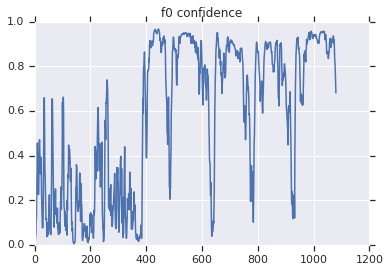

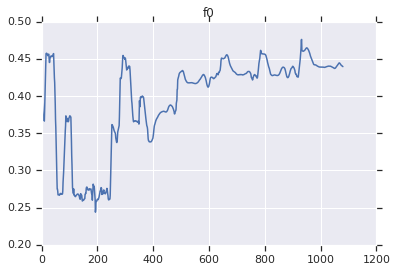

In [0]:
# Original features
plt.figure()
plt.plot(audio_features['f0_confidence'])
plt.title("f0 confidence")

plt.figure()
plt.plot(audio_features['f0'])
plt.title("f0")

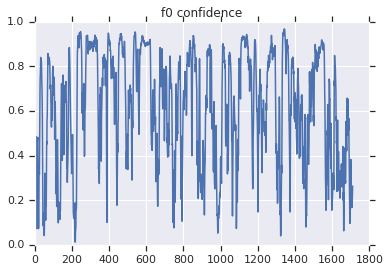

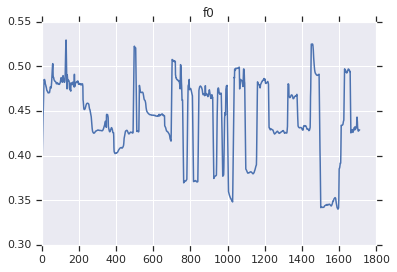

In [0]:
# Modified Features
plt.figure()
plt.plot(audio_features2['f0_confidence'])
plt.title("f0 confidence")

plt.figure()
plt.plot(audio_features2['f0'])
plt.title("f0")

In this block of code we preprocess the input fundamental frequency:


1.   Transpose up by 2 octaves so that singing voice is in range of violin
2.   Mask the f0 and loudness contours to be zero when there is no pitch content

Synthesis can also be run without masking, though there may be some interesting and/or undesired artefacts

(TODO: Automatically transpose f0 to target instrument)


In [0]:
# Choose a confidence masking threshold
# For the violin model, the masking causes fast dips in loudness. This quick transient is interpreted by the model as the "plunk" sound.
CONFIDENCE_LEVEL = 0.3

In [0]:
# TODO(change this to automatically detect the number of octaves to transpose by ensuring lowest note of input is above lowest note of target innstrument range)
OCTAVE_MULTPLIER = 2

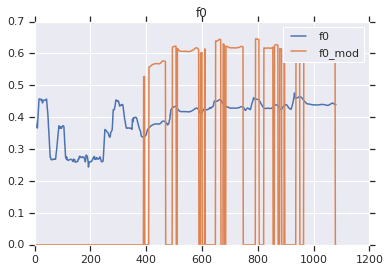

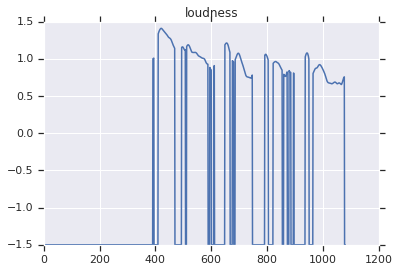

In [0]:
### Shift fundamental frequency
f0_mod = audio_features['f0'].copy()
multiplier = OCTAVE_MULTPLIER
octave_offset = 12.0 / 127.0
offset = multiplier * octave_offset
f0_mod += offset


### Pick loudness to use
# l_mod = audio_features['loudness'].copy()  ## Use the dry loudness.
l_mod = audio_features2['loudness'].copy()  ## Use the wet loudness.


### Smooth loudenss
# M = 0
# smoothing_filter = np.ones([M]) / float(M)
# l_mod = np.convolve(l_mod, smoothing_filter, mode='same')  ## smoothing

### Mask loudenss and f0 by f0_confidence
# f0_mod[f0_mod < (0.3 + offset)] = 0.0
confidence_level = CONFIDENCE_LEVEL
f0_mod[audio_features['f0_confidence'] < confidence_level] = 0.0
l_mod[audio_features['f0_confidence'] < confidence_level] = -1.5


### Plot
plt.figure()
plt.plot(audio_features['f0'])
plt.plot(f0_mod)
plt.title("f0")
plt.legend(['f0', 'f0_mod'])

plt.figure()
plt.plot(l_mod)
plt.title("loudness")

## Ensure dimensions and sampling rates area equal

In [0]:
HOP_SIZE = eval_util.AUDIO_CONFIG['hop_length']
TIME_STEPS = int(audio.shape[0] / HOP_SIZE)
N_SAMPLES_TRANSFER = TIME_STEPS * HOP_SIZE

# print("HOP_SIZE", HOP_SIZE)
# print("TIME_STEPS", TIME_STEPS)
# print("N_SAMPLES_TRANSFER", N_SAMPLES_TRANSFER)

In [0]:
# Trim all input vectors to correct lengths 
for k in ['f0', 'f0_confidence', 'loudness']:
  audio_features[k] = audio_features[k][:TIME_STEPS]
  audio_features2[k] = audio_features2[k][:TIME_STEPS]

for k in ['audio']:
  audio_features[k] = audio_features[k][:N_SAMPLES_TRANSFER]
  audio_features2[k] = audio_features2[k][:N_SAMPLES_TRANSFER]

## Reload model with new shapes

In [0]:
GIN_FILES = [os.path.join(MODEL_DIR, 'operative_config-0.gin')]
GIN_PARAMS = ['additive/synths.Additive.n_samples = {}'.format(N_SAMPLES_TRANSFER),
              'noise/synths.FilteredNoise.n_samples = {}'.format(N_SAMPLES_TRANSFER),
              ]

with gin.unlock_config():
  gin.parse_config_files_and_bindings(GIN_FILES, GIN_PARAMS)

with gin.unlock_config():
  gin.parse_config(['preprocessing.DefaultPreprocessor.time_steps = {}'.format(TIME_STEPS)])


## Define Graph

In [0]:
# Set up the model just to predict audio given new conditioning
tf.reset_default_graph()

model = model_lib.Model()
features_tf = {k:f32(v)[tf.newaxis, :] for k, v in audio_features.items()}

# Add modified features
features_tf['f0'] = f32(f0_mod)[tf.newaxis, :]
features_tf['loudness'] = f32(l_mod)[tf.newaxis, :]

predictions = model.get_outputs(features_tf, is_training=False)

# Setup the session.
# sess = tf.Session('uptc://prod/dragonfish_2x2')
sess = tf.Session()

model.restore(sess, MODEL_DIR)

In [0]:
# Run a batch of predictions.
start_time = time.time()
predictions_ = sess.run(predictions)
print('Prediction took %.1f seconds' % (time.time() - start_time))

Prediction took 1.7 seconds


## Analyze results

In [0]:
# Predictions
k = 0

# Get audio
#audio = features_['audio'][k]
audio_synth = predictions_['audio_gen'][k]
audio_synth_pre_effect = predictions_['add']['signal'][k]
audio_additive = predictions_['additive']['signal'][k]
audio_noise = predictions_['noise']['signal'][k]

# Get controls
add_controls_ = predictions_['additive']['controls']
amps = predictions_['additive']['controls']['amplitudes'][k]
harmonic_distribution =  predictions_['additive']['controls']['harmonic_distribution'][k]
noise_magnitudes =  predictions_['noise']['controls']['magnitudes'][k]
ir = predictions_['reverb']['controls']['impulse_response'][k]

# Get conditioning
f0_hz = predictions_['f0_hz'][k]
loudness = predictions_['loudness'][k]

# Normalize audio
AUDIO_RMS_DRY = rms(audio_synth_pre_effect)
audio_synth_pre_effect = norm_rms(audio_synth_pre_effect)
audio_additive = norm_rms(audio_additive)
audio_noise = norm_rms(audio_noise)


print('Original')
play(audio)
print('Resynthesis')
play(audio_synth)
print('No Reverb')
play(audio_synth_pre_effect)
print('Additive')
play(audio_additive)
print('Noise')
play(audio_noise)

Original


Resynthesis


No Reverb


Additive


Noise


In [0]:
# # Plot Amps and Loudness
# f, ax = plt.subplots(1, 2, figsize=(16, 4))
# ax[0].semilogy(amps)
# ax[0].set_title('Amps')
# ax[1].plot(loudness)
# ax[1].set_title('loudness')

# # Plot audio spectra
# specplot(audio)
# plt.title('Audio')

# specplot(audio_synth)
# plt.title('Audio Synth')

# specplot(audio_synth_pre_effect)
# plt.title('Audio Synth Dry')

# specplot(audio_additive)
# plt.title('Audio Additive')

# specplot(audio_noise)
# plt.title('Audio Noise')

# # plt.figure()
# # plt.semilogy(harmonic_distribution)
# # plt.title('Harmonic Distribution')

# figsize = (16, 12)

# matfig = plt.figure(figsize=figsize)
# plt.matshow(np.rot90(np.log(harmonic_distribution[:, -40:] + 1e-7)), fignum=matfig.number, aspect='auto')
# plt.title('Harmonic Distribution')

# matfig = plt.figure(figsize=figsize)
# plt.matshow(np.rot90(np.log(noise_magnitudes + 1e-7)), fignum=matfig.number, aspect='auto')
# plt.title('Noise Magnitudes')

# plt.figure(figsize=(16, 4))
# plt.plot(ir)
# plt.title('Impulse Response')


# plt.figure()
# plt.plot(f0_hz)
# plt.title('F0_Hz')

# predictions_['total_loss']
